# Compute aggregate over neighbor bands

In [13]:
import geoengine as ge
import numpy as np
import matplotlib.pyplot as plt

In [14]:
ge.initialize("http://localhost:3030/api")

## create a multiband raster by stacking

In [15]:
scales = [1, 2, 2, 4, 8]

bands = [ge.workflow_builder.operators.Expression(f"A * {scale}",  ge.workflow_builder.operators.GdalSource("ndvi")) for scale in scales]

stack = ge.workflow_builder.operators.RasterStacker(sources = bands)

workflow_dict = stack.to_workflow_dict()

workflow = ge.register_workflow(workflow_dict)

query = ge.QueryRectangle(
    ge.BoundingBox2D(-111.533203125, -4.482421875, 114.345703125, 73.388671875),
    ge.TimeInterval(np.datetime64('2014-04-01')),
    ge.SpatialResolution(0.1, 0.1)
)

xarray = await workflow.raster_stream_into_xarray(query_rectangle=query, bands=list(range(len(scales))))

xarray


<xarray.DataArray (time: 1, band: 5, y: 1536, x: 3072)>
array([[[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [ 255.,  255.,  255., ...,  255.,  255.,  255.],
         [ 255.,  255.,  255., ...,  255.,  255.,  255.],
         [ 255.,  255.,  255., ...,  255.,  255.,  255.]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [ 510.,  510.,  510., ...,  510.,  510.,  510.],
         [ 510.,  510.,  510., ...,  510.,  510.,  510.],
         [ 510.,  510.,  510., ...,  510.,  510.,  510.]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [ 510.,  510.,  510., ...,  510.,  510.,  510.],
         [ 510.,  510.,  510., ...,  510.,  510.,  510.],
         [ 510.,  510.,  510., ...,  510.,  510.,  510.]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [1020., 1020., 1020., ..., 1020., 1020., 1020.],
         [1020., 1020., 1020., ..., 1020., 1020., 1020.],
         [1020., 1020., 1020., ..., 1020., 1020., 1020.]],

        [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         [  nan,   nan,   nan, ...,   nan,   nan,   nan],
         ...,
         [2040., 2040., 2040., ..., 2040., 2040., 2040.],
         [2040., 2040., 2040., ..., 2040., 2040., 2040.],
         [2040., 2040., 2040., ..., 2040., 2040., 2040.]]]], dtype=float32)
Coordinates:
  * x            (x) float64 -153.6 -153.5 -153.4 -153.3 ... 153.3 153.4 153.5
  * y            (y) float64 102.4 102.3 102.2 102.1 ... -50.95 -51.05 -51.15
  * time         (time) datetime64[ns] 2014-04-01
  * band         (band) int64 0 1 2 3 4
    spatial_ref  int64 0

## Plot a single pixel over all bands

In [16]:
def plot_xarray(xarray):
    x = 200
    y = 200

    # Extract the values for all bands at the selected pixel
    pixel_values = xarray.isel(x=x, y=y).values

    # Since the DataArray has dimensions (time, band, y, x), we need to squeeze out the time dimension
    pixel_values = pixel_values.squeeze()

    # Create a list of band indices
    band_indices = range(pixel_values.shape[0])

    # Plot the values
    plt.figure(figsize=(4, 4))
    plt.plot(band_indices, pixel_values, marker='o')
    plt.title(f'Band Values for Pixel ({x}, {y})')
    plt.xlabel('Band Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()


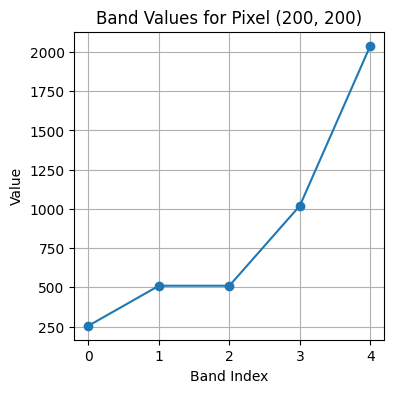

In [17]:
plot_xarray(xarray)

## Moving average of 3 bands

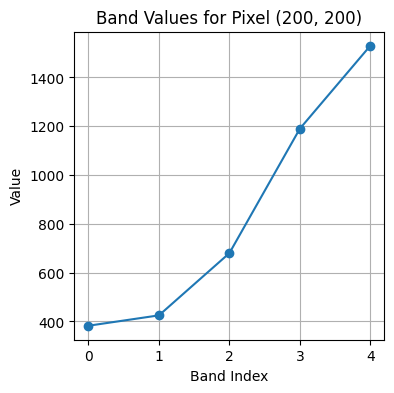

In [18]:
workflow_avg_dict = ge.workflow_builder.operators.BandNeighborhoodAggregate(aggregate=ge.workflow_builder.operators.BandNeighborhoodAggregateParams.average(3), source=stack)

workflow_avg = ge.register_workflow(workflow_avg_dict)

xarray_avg = await workflow_avg.raster_stream_into_xarray(query_rectangle=query, bands=list(range(len(scales))))

plot_xarray(xarray_avg)

## 1st Derivative

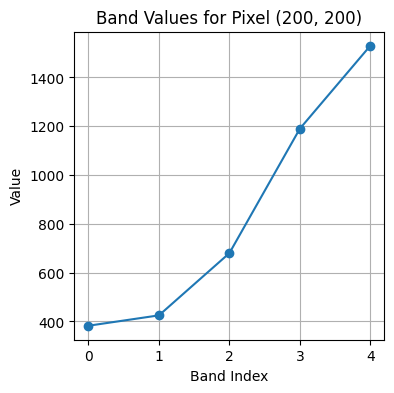

In [19]:
workflow_1st_derivative_dict = ge.workflow_builder.operators.BandNeighborhoodAggregate(aggregate=ge.workflow_builder.operators.BandNeighborhoodAggregateParams.first_derivative(1), source=stack)

workflow_1st_derivative = ge.register_workflow(workflow_1st_derivative_dict)

xarray_1st_derivative = await workflow_1st_derivative.raster_stream_into_xarray(query_rectangle=query, bands=list(range(len(scales))))

plot_xarray(xarray_1st_derivative)